# Neural Network model

### Package Installation

To use R for deep learning, we first need to install `keras`, which provides an interface to `TensorFlow`.

In [ ]:
install.packages("keras") # you'll need to install keras every time you start a new session in colab

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’




In [ ]:
set.seed(0) # reproducibility

In [ ]:
library(keras) # load keras
library(readr) # to read in data from github

### Reading in data

Here we read in the simulated data from github. The X's are simulated from a multivariate Gaussian distribution with an autoregressive covariance structure.

Specifically, 
\begin{align*}
\mathbf{X} &\sim \mathcal{N}\left(0, \Sigma \right),
\end{align*}
with 
\begin{align*}
\Sigma &= \begin{bmatrix}
1 & 0.9 & 0.9^2 & \cdots & 0.9^{29} \\
0.9 & 1 & 0.9 & \cdots & 0.9^{28} \\
\vdots & \vdots & \ddots & \cdots & \vdots \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0.9^{29} & 0.9^{28} & 0.9^{27} & \cdots & 1
\end{bmatrix}.
\end{align*}

The responses are generated as a non-linear function of five of the 30 predictors.

The data are stored on github and loaded from there.
However, you can also upload csv files directly to Colab instead of using github. 
If you upload the data to Colab, you will need to then upload the files every time you start a new Colab session.

In [ ]:
test = read_csv("https://raw.githubusercontent.com/Qingyang-Liu47/STATS415-FINAL-PROJECT/main/kaggle_test_selected_18.csv")
train = read_csv("https://raw.githubusercontent.com/Qingyang-Liu47/STATS415-FINAL-PROJECT/main/kaggle_train_selected_18.csv")

Rows: 3823 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (18): RIAGENDR, RIDAGEYR, SIAPROXY, BMXWT, BMXHT, BMXBMI, BMXLEG, BMXARM...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8921 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (19): y, RIAGENDR, RIDAGEYR, SIAPROXY, BMXWT, BMXHT, BMXBMI, BMXLEG, BMX...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Before bothering with any neural networks, it's a good idea to fit a linear model to the data to get a baseline level of prediction performance.

Of the 30 predictors in the data set, we used five to generate the response. 
Those are $X_3, X_4, X_{11}, X_{22},$ and $X_{25}$. 
We can see if the linear model identifies any of these predictors. 

In [ ]:
# split training set
set.seed(27)
train_idx = sample(1:nrow(train), floor(0.8 * nrow(train)), replace = FALSE)
train_df = train[train_idx, ]
test_df = train[-train_idx, ]
#val_idx = sample(1:nrow(test_df), floor(0.5 * nrow(test_df)), replace = FALSE)
#val_df = test_df[val_idx, ]
#test2_df = test_df[-val_idx, ]
str(train_df)
str(test_df)
#str(val_df)
#str(test2_df)

tibble [7,136 × 19] (S3: tbl_df/tbl/data.frame)
 $ y       : num [1:7136] 6.111 1.53 -1.799 0.438 2.571 ...
 $ RIAGENDR: num [1:7136] 0.997 0.997 0.997 0.997 -1.003 ...
 $ RIDAGEYR: num [1:7136] -1.292 -0.417 -0.708 0.555 -1.146 ...
 $ SIAPROXY: num [1:7136] 0.343 0.343 0.343 0.343 0.343 ...
 $ BMXWT   : num [1:7136] -1.2 0.11 0.5 1.01 2.21 ...
 $ BMXHT   : num [1:7136] -0.4988 0.16 -1.487 -0.0996 0.8088 ...
 $ BMXBMI  : num [1:7136] -1.1626 0.0581 1.5582 1.2199 1.9258 ...
 $ BMXLEG  : num [1:7136] 0.0462 0.2067 -1.3444 -0.1945 1.8112 ...
 $ BMXARML : num [1:7136] -1.593 -0.287 -0.957 0.561 1.655 ...
 $ BMXARMC : num [1:7136] -1.7494 0.0334 1.1594 0.8591 1.1594 ...
 $ BMXWAIST: num [1:7136] -1.339 -0.299 0.973 1.14 1.516 ...
 $ DR1TKCAL: num [1:7136] 0.439 0.331 -0.129 -1.451 -1.183 ...
 $ DR1TCARB: num [1:7136] 0.402 1.046 -0.818 -0.916 -1.14 ...
 $ DR1TSUGR: num [1:7136] -0.4366 1.6778 -1.1669 0.0411 -0.8547 ...
 $ DR1TFIBE: num [1:7136] -0.0724 -0.5667 -0.2963 -0.9863 -1.1542 ...
 $

In [ ]:
# fit a linear model
fit = lm(y ~ ., data=train_df)
summary(fit)


Call:
lm(formula = y ~ ., data = train_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-21.6384  -1.6710   0.0983   1.6906  26.3876 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.16247    0.03580  32.468  < 2e-16 ***
RIAGENDR     0.11877    0.05018   2.367 0.017972 *  
RIDAGEYR    -0.37906    0.05495  -6.898 5.72e-12 ***
SIAPROXY    -0.15852    0.05455  -2.906 0.003676 ** 
BMXWT        7.81164    0.34818  22.435  < 2e-16 ***
BMXHT       -3.03428    0.16736 -18.130  < 2e-16 ***
BMXBMI      -5.71767    0.31797 -17.982  < 2e-16 ***
BMXLEG      -0.11379    0.06305  -1.805 0.071175 .  
BMXARML     -0.73865    0.07024 -10.516  < 2e-16 ***
BMXARMC     -0.60584    0.10283  -5.891 4.00e-09 ***
BMXWAIST    -1.16166    0.12730  -9.125  < 2e-16 ***
DR1TKCAL    -0.43028    0.08127  -5.295 1.23e-07 ***
DR1TCARB     0.01708    0.12474   0.137 0.891109    
DR1TSUGR    -0.30176    0.07758  -3.890 0.000101 ***
DR1TFIBE     0.49946    0.04958  10.073  <

In [ ]:
mean((fit$fitted.values - train_df$y)^2) # calculate training MSE
mean((predict(fit, test_df) - test_df$y)^2) # calculate test MSE

[1] 9.118336

[1] 7.981383

In [ ]:
preds_lm = predict(fit, test_df)
cor(preds_lm, test_df$y)^2  # calculate test r^2 to compare with later models

[1] 0.3288449

In this case, since the outcomes were generated as a non-linear function of the covariates, the linear model does not do a very good job fitting the data. 
We'll try to improve performance by fitting a neural network.

## Neural Networks in R

### Preparing the data for `keras`

`keras` expects the input to be a matrix object, so (following the example in Chapter 10 of ISLR2) we'll convert the data frames to matrices here.

In [ ]:
## Keras needs the data in matrix form
xTr = model.matrix(lm(y ~ . - 1, data=train_df))
yTr = train_df$y
xTe = model.matrix(lm(y ~ . - 1, data=test_df))
yTe = test_df$y
#xTe_1 = model.matrix(lm(y ~ . - 1, data=val_df))
#yTe_1 = val_df$y
#xTe_2 = model.matrix(lm(y ~ . - 1, data=test2_df))
#yTe_2 = test2_df$y

In [ ]:
ncol(xTr)
class(xTr)

[1] 18

[1] "matrix" "array"

As an aside - what if we don't have any hidden layers?

In this case, our model is identical to linear regression (solution will be slightly different since we're using stochastic optimization and `lm()` is solving for the OLS solution exactly).

First we will create a neural network with two hidden layers and see how the model performs.

Our test set performance is much better than the linear model, but it ooks like our model overfits. 
The training set has almost 0 MSE (and near 100% r^2).

How can we fix that?

*   Weight decay
*   Dropout
*   Learning rate scheduling
*   Batch norm
*   Early stopping

We'll take a look at each of these to try to improve our model's performance.


## Deep learning "tricks"

In this section we'll explore some common techniques used to improve the performance of deep neural networks.

### Weight decay

Using an $\ell_2$ penalty on the neural network weights is called weight decay. 
This is the same penalty that is used in ridge regression, except now it can be applied to multiple layers in the network.

In the model above, we add a penalty of 0.1 to each weight in the two hidden layers. In practice we would want to tune our model by trying out different amounts of regularization to see which gives the best validation set performance.

Now we can fit the model as we did earlier.


It seems that the model is still overfitting, but there is slightly improved out of sample performance when using weight decay.

### Dropout

Another form of regularization for neural networks is dropout.
It was developed by Geoffrey Hinton in 2012.

At each iteration, a fraction $\phi$ of the units in a layer is set to 0. 
The weights of the non-zero units are scaled up by a factor of $1 / (1 - \phi)$ to compensate.

We'll add dropout layers with $\phi = 0.4$ to our network (though in practice you'll need to tune this probability using a validation set).

### Learning rate scheduling

Another technique for reducing overfitting is to gradually reduce the learning rate as the model continues to train.

In `keras` we can do that with a learning rate scheduler.

We will use `callback_reduce_lr_on_plateau`, which reduces the learning rate when some validation set metric (in this case, mean squared error) stops going down.

### Batch normalization

Batch normalization is a technique for speeding up and stabilizing training of neural networks. 
It was invented in 2015 by Sergey Ioffe and Christian Szegedy.

Batch norm works by re-centering and re-scaling (mean 0 and unit variance) the inputs after each layer. 

In [ ]:
callbacks_list = list(callback_reduce_lr_on_plateau(monitor = "val_loss"))

Loaded Tensorflow version 2.8.0



In [ ]:
modnn <- keras_model_sequential () %>%
layer_dense(units = 128, kernel_regularizer = regularizer_l2(0.00001)) %>%
layer_batch_normalization() %>%
layer_dropout(rate=0.05) %>%
layer_activation_relu() %>%
layer_dense(units = 128, kernel_regularizer = regularizer_l2(0.00001)) %>%
layer_batch_normalization() %>%
layer_dropout(rate=0.05) %>%
layer_activation_relu() %>%
  layer_dense(units = 1)

In [ ]:
modnn %>% compile(loss = "mse",
optimizer = optimizer_rmsprop(learning_rate=0.005))

In [ ]:
set.seed(123)
start_time <- Sys.time()
history <- modnn %>% fit(
xTr, yTr, epochs = 150, batch_size = 128,
validation_data = list(xTe, yTe),
callbacks = callbacks_list
)
end_time <- Sys.time()
end_time - start_time

Time difference of 42.37155 secs

`geom_smooth()` using formula 'y ~ x'



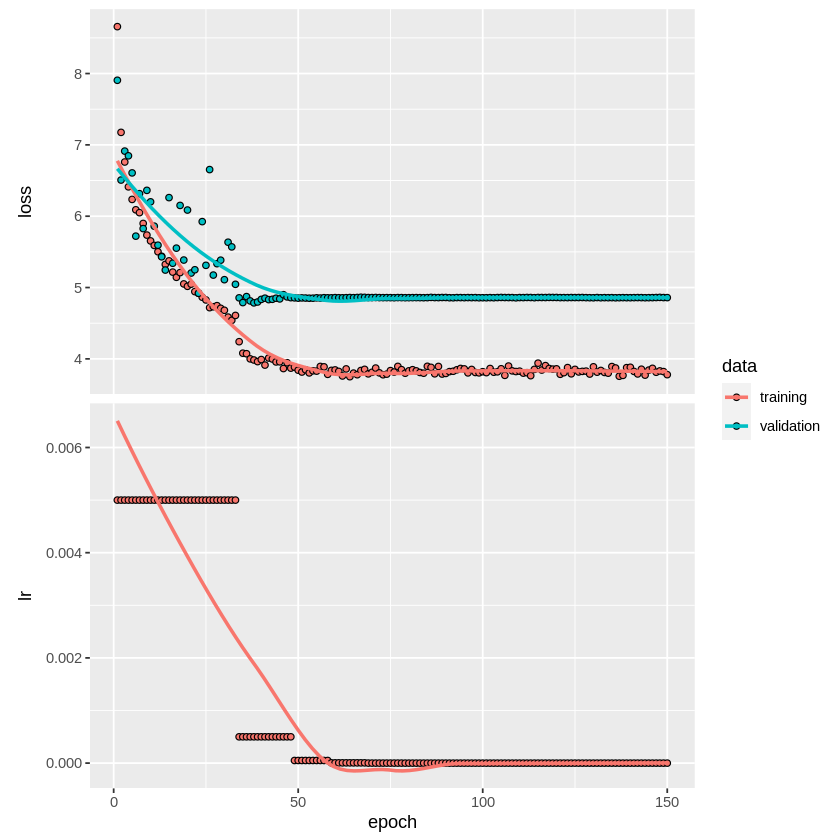

In [ ]:
plot(history)

In [ ]:
npred_tr <- c(predict(modnn , xTr))
npred_te <- c(predict(modnn , xTe))
#npred_te_1 <- c(predict(modnn , xTe_1))
#npred_te_2 <- c(predict(modnn , xTe_2))
(batch_norm_tr <- cor(npred_tr, yTr)^2)
(batch_norm_te <- cor(npred_te, yTe)^2)
#(batch_norm_te_1 <- cor(npred_te_1, yTe_1)^2) # val r^2
#(batch_norm_te_2 <- cor(npred_te_2, yTe_2)^2) # test r^2

[1] 0.7532609

[1] 0.5946118

In [ ]:
test_mat = as.matrix(test)
y = predict(modnn, test_mat)

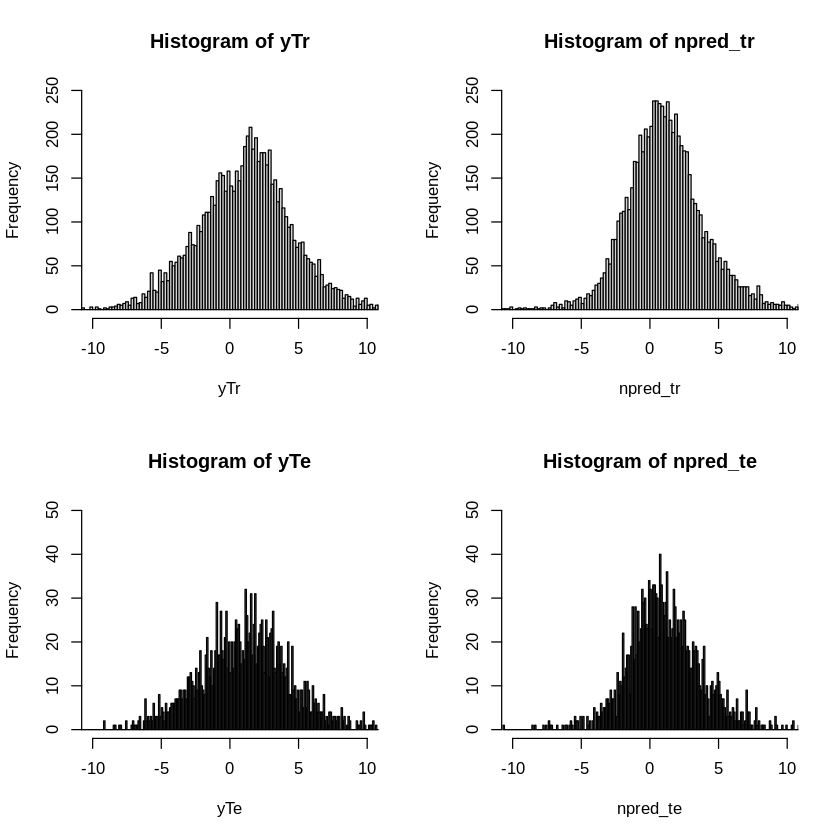

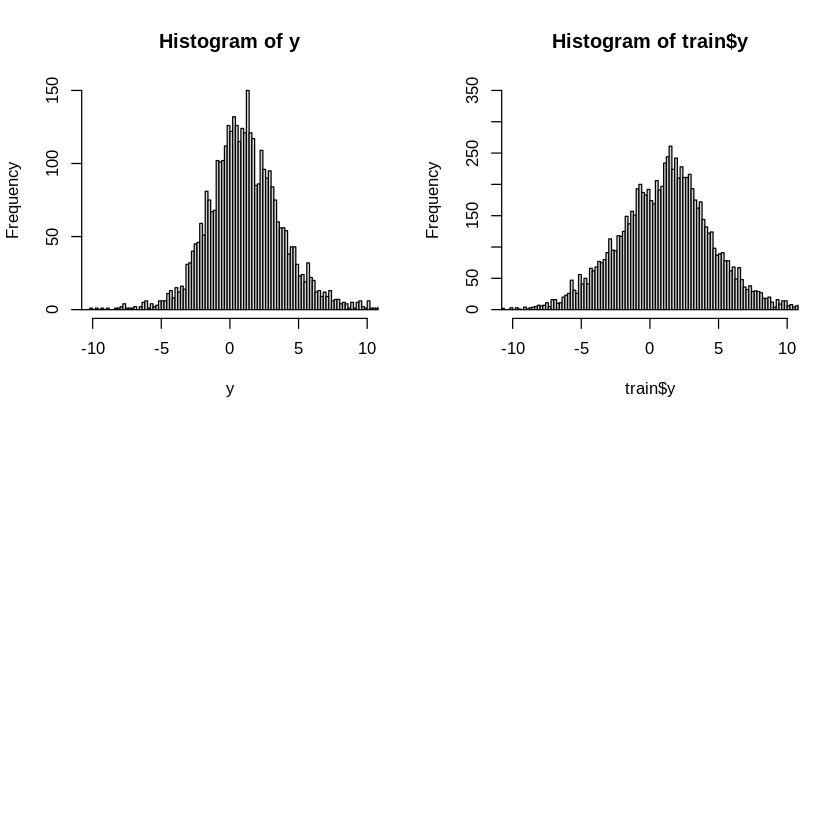

In [ ]:
par(mfrow=c(2,2))
hist(yTr, xlim=c(-10, 10), ylim = c(0, 250), breaks = 250)
hist(npred_tr,xlim=c(-10, 10), ylim = c(0, 250), breaks = 250)
hist(yTe,xlim=c(-10, 10), ylim = c(0, 50), breaks = 250)
hist(npred_te,xlim=c(-10, 10), ylim = c(0, 50), breaks = 250)
#hist(yTe_1,xlim=c(-10, 10), ylim = c(0, 50), breaks = 250)
#hist(npred_te_1,xlim=c(-10, 10), ylim = c(0, 50), breaks = 250)
#hist(yTe_2,xlim=c(-10, 10), ylim = c(0, 50), breaks = 250)
#hist(npred_te_2,xlim=c(-10, 10), ylim = c(0, 50), breaks = 250)
hist(y,xlim=c(-10, 10), ylim = c(0, 150), breaks = 250)
hist(train$y, xlim=c(-10, 10), ylim = c(0, 350), breaks = 250)

In [ ]:
test_org = read.csv("https://raw.githubusercontent.com/Qingyang-Liu47/STATS415-FINAL-PROJECT/main/test.csv")
test_org$y = c(y)
head(test_org)

,SEQN,y
,<int>,<dbl>
1,62163,5.1146793
2,62171,2.0936306
3,62178,-1.7814778
4,62180,0.9106938
5,62189,2.0060718
6,62200,0.3321084


In [ ]:
write_csv(test_org, "kaggle_submission_0414_18_59.csv")

In [23]:
curr_best = read.csv("/content/kaggle_submission_0415_22_613 (1) (1).csv")

In [24]:
y <- curr_best$y
proxy_df <- data.frame(y, test)
str(proxy_df)

'data.frame':	3823 obs. of  19 variables:
 $ y       : num  4.76 2.22 -2.21 1.44 2.09 ...
 $ RIAGENDR: num  -1.003 -1.003 -1.003 -1.003 0.997 ...
 $ RIDAGEYR: num  -1.389 -1.389 1.818 -0.368 -0.611 ...
 $ SIAPROXY: num  -2.917 -2.917 0.343 0.343 0.343 ...
 $ BMXWT   : num  -1.365 -0.956 0.333 0.477 -1.133 ...
 $ BMXHT   : num  0.19 0.4 0.649 1.168 -1.098 ...
 $ BMXBMI  : num  -1.5891 -1.2068 0.0581 -0.0302 -0.8391 ...
 $ BMXLEG  : num  0.34 0.18 -0.489 0.421 -1.05 ...
 $ BMXARML : num  -0.28655 -0.95741 -0.53371 -0.00408 -1.09864 ...
 $ BMXARMC : num  -1.937 -1.186 -0.436 0.578 -1.093 ...
 $ BMXWAIST: num  -1.824 -1.42 0.944 0.4 -0.923 ...
 $ DR1TKCAL: num  -0.3328 -0.2087 -0.0198 0.4502 -0.2959 ...
 $ DR1TCARB: num  0.191 0.371 0.369 0.343 -0.268 ...
 $ DR1TSUGR: num  0.0305 0.9405 0.6523 -0.0462 0.1825 ...
 $ DR1TFIBE: num  -0.884 -0.539 -0.268 0.552 -1.005 ...
 $ SMAQUEX2: num  2.255 2.255 -0.443 -0.443 -0.443 ...
 $ LBXTC   : num  -0.706 -1.558 0.408 -0.966 -1.179 ...
 $ LBDTCSI : 

In [25]:
set.seed(27)
idx = sample(1:nrow(proxy_df), floor(0.7*nrow(proxy_df)), replace = FALSE)
train_df_2 <- proxy_df[idx, ]
new_train <- rbind(train_df, train_df_2)
str(new_train)
str(test_df)
# split training set

tibble [9,812 × 19] (S3: tbl_df/tbl/data.frame)
 $ y       : num [1:9812] 6.111 1.53 -1.799 0.438 2.571 ...
 $ RIAGENDR: num [1:9812] 0.997 0.997 0.997 0.997 -1.003 ...
 $ RIDAGEYR: num [1:9812] -1.292 -0.417 -0.708 0.555 -1.146 ...
 $ SIAPROXY: num [1:9812] 0.343 0.343 0.343 0.343 0.343 ...
 $ BMXWT   : num [1:9812] -1.2 0.11 0.5 1.01 2.21 ...
 $ BMXHT   : num [1:9812] -0.4988 0.16 -1.487 -0.0996 0.8088 ...
 $ BMXBMI  : num [1:9812] -1.1626 0.0581 1.5582 1.2199 1.9258 ...
 $ BMXLEG  : num [1:9812] 0.0462 0.2067 -1.3444 -0.1945 1.8112 ...
 $ BMXARML : num [1:9812] -1.593 -0.287 -0.957 0.561 1.655 ...
 $ BMXARMC : num [1:9812] -1.7494 0.0334 1.1594 0.8591 1.1594 ...
 $ BMXWAIST: num [1:9812] -1.339 -0.299 0.973 1.14 1.516 ...
 $ DR1TKCAL: num [1:9812] 0.439 0.331 -0.129 -1.451 -1.183 ...
 $ DR1TCARB: num [1:9812] 0.402 1.046 -0.818 -0.916 -1.14 ...
 $ DR1TSUGR: num [1:9812] -0.4366 1.6778 -1.1669 0.0411 -0.8547 ...
 $ DR1TFIBE: num [1:9812] -0.0724 -0.5667 -0.2963 -0.9863 -1.1542 ...
 $

In [26]:
xTr_a = model.matrix(lm(y ~ . - 1, data=new_train))
yTr_a = new_train$y

In [43]:
callbacks_list = list(callback_reduce_lr_on_plateau(monitor = "val_loss"))

In [44]:
modnn <- keras_model_sequential () %>%
layer_dense(units = 128, kernel_regularizer = regularizer_l2(0.000001)) %>%
layer_batch_normalization() %>%
layer_dropout(rate=0.02) %>%
layer_activation_relu() %>%
layer_dense(units = 128, kernel_regularizer = regularizer_l2(0.000001)) %>%
layer_batch_normalization() %>%
layer_dropout(rate=0.05) %>%
layer_activation_relu() %>%
  layer_dense(units = 1)

In [45]:
modnn %>% compile(loss = "mse",
optimizer = optimizer_adam(learning_rate=0.008))

In [46]:
set.seed(123)
start_time <- Sys.time()
history <- modnn %>% fit(
xTr_a, yTr_a, epochs = 150, batch_size = 128,
validation_data = list(xTe, yTe),
callbacks = callbacks_list
)
end_time <- Sys.time()
end_time - start_time

Time difference of 45.38178 secs

`geom_smooth()` using formula 'y ~ x'



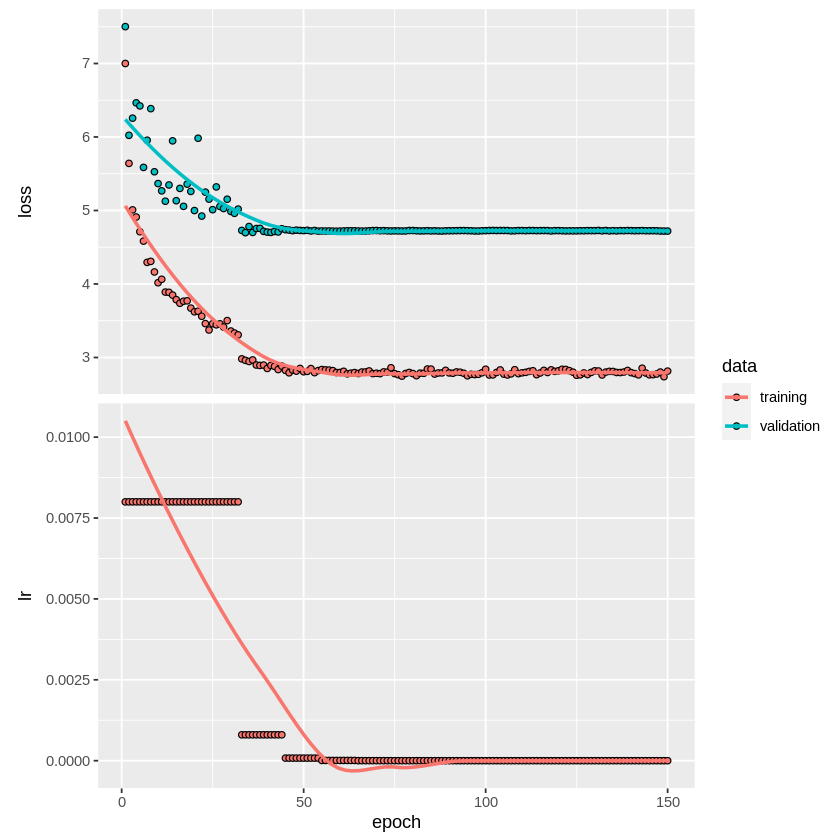

In [47]:
plot(history)

In [48]:
#npred_te_11 <- c(predict(modnn , xTe_1))
#npred_te_12 <- c(predict(modnn , xTe_2))
npred_tr <- c(predict(modnn , xTr_a))
npred_te <- c(predict(modnn , xTe))
(batch_norm_tr <- cor(npred_tr, yTr_a)^2) # train r^2
(batch_norm_te <- cor(npred_te, yTe)^2) # test r^2
#(batch_norm_te_11 <- cor(npred_te_11, yTe_1)^2) # test r^2
#(batch_norm_te_11 <- cor(npred_te_12, yTe_2)^2) # test r^2

[1] 0.8057265

[1] 0.6051718

In [49]:
test_mat = as.matrix(test)
y_1 = predict(modnn, test_mat)

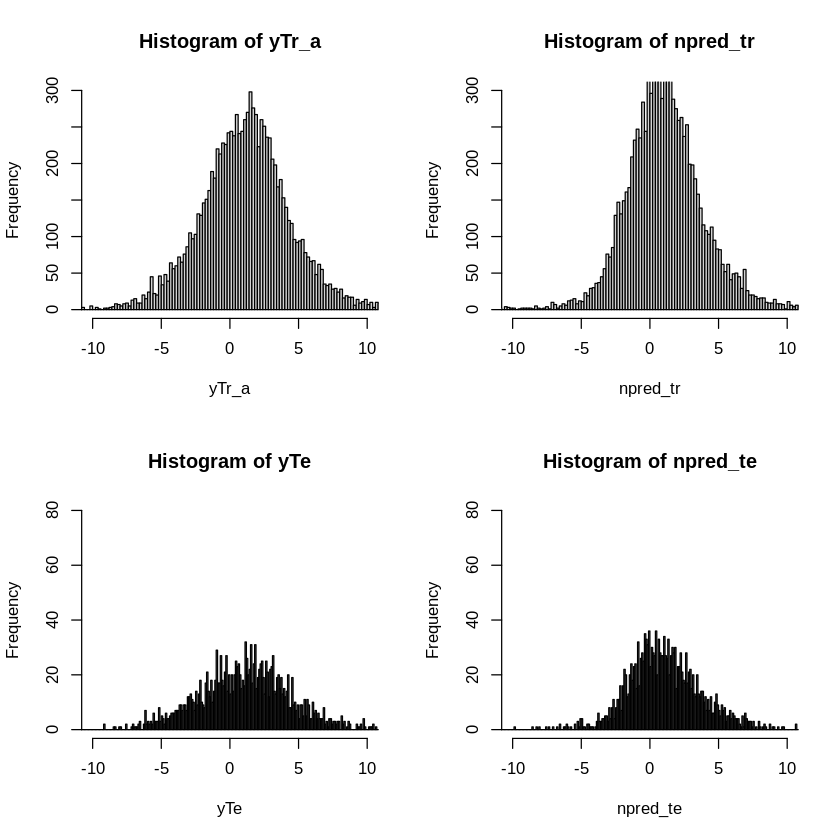

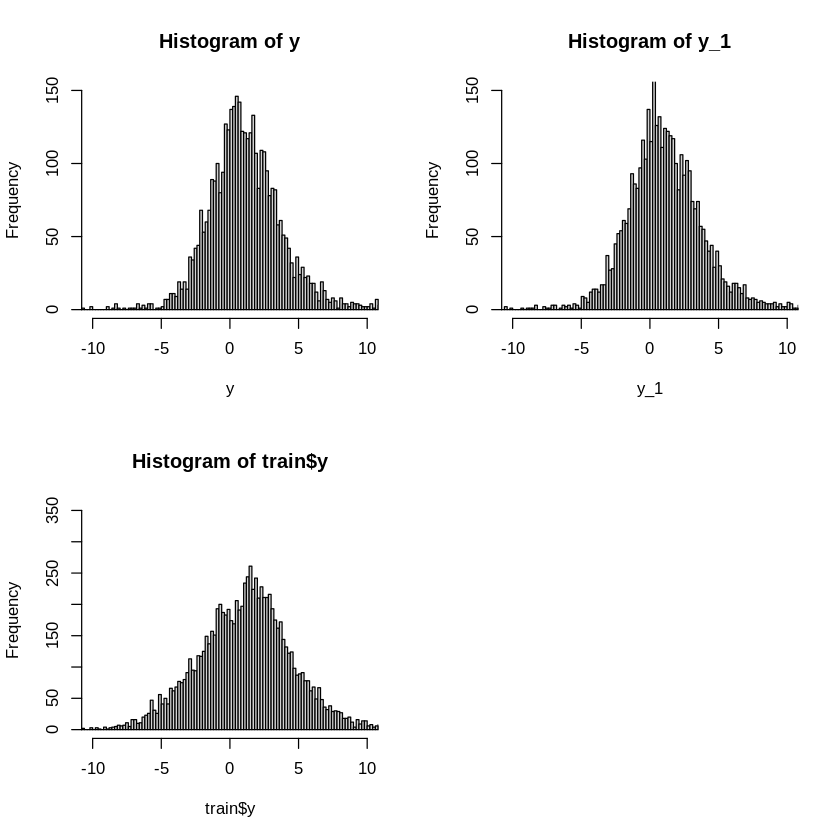

In [50]:
par(mfrow=c(2,2))
hist(yTr_a, xlim=c(-10, 10),  ylim = c(0, 300), breaks = 250)
hist(npred_tr, xlim=c(-10, 10), ylim = c(0, 300), breaks = 250)
#hist(yTe_1,xlim=c(-10, 10), ylim = c(0, 80), breaks = 250)
#hist(npred_te_11,xlim=c(-10, 10), ylim = c(0, 80), breaks = 250)
hist(yTe,xlim=c(-10, 10), ylim = c(0, 80), breaks = 250)
hist(npred_te,xlim=c(-10, 10), ylim = c(0, 80), breaks = 250)
hist(y,xlim=c(-10, 10), ylim = c(0, 150), breaks = 250)
hist(y_1,xlim=c(-10, 10), ylim = c(0, 150), breaks = 250)
hist(train$y, xlim=c(-10, 10), ylim = c(0, 350), breaks = 250)

In [35]:
test_org = read.csv("https://raw.githubusercontent.com/Qingyang-Liu47/STATS415-FINAL-PROJECT/main/test.csv")
test_org$y = c(y_1)
head(test_org)

,SEQN,y
,<int>,<dbl>
1,62163,5.11534214
2,62171,2.24787521
3,62178,-2.47012424
4,62180,1.04317963
5,62189,1.78294826
6,62200,0.07338582


In [51]:
write_csv(test_org, "kaggle_submission_0415_18_605.csv")